<a id="top"></a>
# Correcting for Scattered Light in WFC3/IR Exposures: Using `calwf3` to Mask Bad Reads


## Learning Goals

This notebook shows one of two available methods to correct for time-variable background 
(TVB) due to scattered light from observing close to the Earth's limb. This method illustrates how to mask bad reads in the RAW image and then reprocess with calwf3, and it may be used for rejecting anomalous reads occurring either at the beginning or at the end of an exposure.


By the end of this tutorial, you will:

- Compute and plot the difference between IMA reads to identify the reads affected by TVB. 
- Reprocess a single exposure with `calwf3` by excluding the first few reads which are affected by scattered light.
- Compare the original FLT to the reprocessed FLT image.

A second method (manually subtracting bad reads from the final IMA read) can 
be found in the notebook Correcting for Scattered Light in IR Exposures: Manually Subtracting Bad Reads (O'Connor, in prep.). This provides a method for removing anomalies such as satellite trails which appear in the middle of an IMA exposure.  One caveat of the second method is that it does not perform the 'ramp fitting' step and therefore the calibrated FLT products will still contain cosmic rays.  

<div class="alert alert-block alert-info">

**Please note that this method may leave large sky residuals in regions 
corresponding to IR 'blobs', flagged in the FLT data quality (DQ) array as a value of 512. This method is therefore recommended for observations acquired using an WFC3-IR-
DITHER-BLOB dither (or POSTARG equivalent) to step over blob regions. Software such
as AstroDrizzle may then be used to combine the FLT exposures, while excluding pixels 
with 512 flags (or any bit-wise combination of 512 and another flag e.g. 576 = 512 + 64).**

</div>

## Table of Contents

[Introduction](#intro) <br>
[1. Imports](#import) <br>
[2. Downloading Data](#load) <br>
[3. Identifying Reads with Time Variable Background](#identify) <br>
[4. Querying CRDS for the Reference File](#ref) <br>
[5. Reprocessing the Observation](#main) <br>
- [5.1 Re-running `calwf3`](#reprocess) <br>
- [5.2 Comparing FLT Products](#compare) <br>

[6. Drizzling Nominal and Reprocessed FLT Products](#drizzle) <br>
[7. Conclusions](#conclusions) <br>
[Additional Resources](#add) <br>
[About this Notebook](#about) <br>
[Citations](#cite) <br>


## Introduction <a id="intro"></a>

Observations with strong time variability in the sky background during a MULTIACCUM ramp can corrupt the WFC3 calwf3 'linear ramp fit' and cosmic-ray identification algorithm (CRCORR, [Section 3.3.10 of the Data Handbook](https://hst-docs.stsci.edu/wfc3dhb/chapter-3-wfc3-data-calibration/3-3-ir-data-calibration-steps#id-3.3IRDataCalibrationSteps-3.3.10)). The CRCORR 
algorithm assumes that a given pixel sees a constant count rate throughout the read from a 
combination of sources and diffuse background (i.e., the integrated signal "ramps" are linear). A background 
varying strongly with time (i.e. where the "ramps" are non-linear) can trigger the cosmic-ray 
(CR) flagging thresholds in calwf3, causing the algorithm to identify most or all of the pixels as a CR at any given read.

In this notebook we will use an example examine an observation affected by strong TVB, 
specifically due to Earth limb scattered light ([Section 7.10 of the WFC3 Data Handbook](https://hst-docs.stsci.edu/wfc3dhb/chapter-7-wfc3-ir-sources-of-error/7-10-time-variable-background)) affecting the first few reads and producing a spatially variable background. We will run `calwf3` while rejecting the affected reads to create an improved FLT product with a flat background and an improved ramp fit. One caveat is that the new FLT will 
have a reduced total exposure time, given the rejection of some number of reads, and 
therefore a lower signal-to-noise ratio.

Please see the notebook IR IMA Visualization with An Example of Time Variable Background(O'Connor, in prep.) for a walkthrough of how to identify a TVB in due to scattered light. 

## 1. Imports <a id="import"></a>

This notebook assumes you have created the virtual environment in [WFC3 Library's](https://github.com/spacetelescope/WFC3Library) installation instructions.

We import:

- *os* for setting environment variables
- *glob* for finding lists of files
- *shutil* for managing directories
- *numpy* for handling array functions
- *matplotlib.pyplot* for plotting data
- *astropy.io fits* for accessing FITS files
- *astroquery.mast Observations* for downloading data from MAST
- *wfc3tools* `calwf3` for calibrating WFC3 data
- *ginga* for finding min/max outlier pixels

We import the following modules:
- *ima_visualization_and_differencing* to take the difference between reads, plot the ramp, and visualize the difference in images


In [1]:
import os 
import glob
import shutil 
import numpy as np
from matplotlib import pyplot as plt
from astropy.io import fits
from astroquery.mast import Mast
from astroquery.mast import Observations
from wfc3tools import calwf3
from ginga.util.zscale import zscale

import ima_visualization_and_differencing as diff

%matplotlib inline


## 2. Downloading Data<a id="load"></a>

The following commands query MAST for the necessary data products and downloads them to the current directory. Here we obtain WFC3/IR observations from HST Frontier Fields program [14037](https://archive.stsci.edu/proposal_search.php?id=14037&mission=hst), Visit BB. We specifically want the observation `icqtbbbxq`, as it is strongly affected by Earth limb scattered light. The data products requested are the RAW, IMA, and FLT files. For an example of TVB at the end of an exposure, we include an alternate dataset (OBS_ID = `ICXT27020`, file_id = `icxt27hkq`) in which the Earth limb affects the reads at the end of the MULTIACCUM sequence (SCI,1 through  SCI,5). 

**Warning: this cell may take a few minutes to complete.**

In [2]:
OBS_ID = 'ICQTBB020' #Earth-limb at the start 
#OBS_ID = 'ICXT27020' #Earth-limb at the end 
data_list = Observations.query_criteria(obs_id=OBS_ID)

file_id = "icqtbbbxq"
#file_id = 'icxt27hkq'
Observations.download_products(data_list['obsid'], project='CALWF3', obs_id=file_id, 
                mrp_only=False, productSubGroupDescription=['RAW', 'IMA', 'FLT'])




Local Path,Status,Message,URL
str47,str8,object,object
./mastDownload/HST/icqtbbbxq/icqtbbbxq_ima.fits,COMPLETE,None,None
./mastDownload/HST/icqtbbbxq/icqtbbbxq_flt.fits,COMPLETE,None,None
./mastDownload/HST/icqtbbbxq/icqtbbbxq_raw.fits,COMPLETE,None,None


Now, we will move our IMA and FLT files to a separate directory called "orig/" so they are not overwritten when we run `calwf3`. We leave our RAW file in the working directory for later use.

In [3]:
if not os.path.exists('orig/'):
    os.mkdir('orig/')

shutil.copy(f'mastDownload/HST/{file_id}/{file_id}_ima.fits', f'orig/{file_id}_ima.fits')
shutil.copy(f'mastDownload/HST/{file_id}/{file_id}_flt.fits', f'orig/{file_id}_flt.fits')  

raw_file = f'mastDownload/HST/{file_id}/{file_id}_raw.fits'

remove_files_list=glob.glob(f'./{file_id}_*.fits')
for rm_file in remove_files_list:
    os.remove(rm_file)

shutil.copy(raw_file, f'{file_id}_raw.fits')

'icqtbbbxq_raw.fits'

## 3. Identifying Reads with Time Variable Background<a id="identify"></a>

In this section, we show how to identify the reads impacted by TVB by examining the difference in count rate between reads. This section was taken from the [IR IMA Visualization with An Example of Time Variable Background ADD LINK]() notebook, which includes a more comprehensive walkthrough of identifying time variable background in IR images. 

Here we implement a technique to examine the count rate difference between consecutive reads. In this case, we first convert from count rate (electrons/second) back to counts (electrons) before taking the difference, as shown in equation 3 from [WFC3/IR ISR 2018-05](https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/wfc3/documentation/instrument-science-reports-isrs/_documents/2018/WFC3-2018-05.pdf). 

![Instantaneous Difference Equation](instantaneous_diff.png)

We compare sky values in different regions of the detector (left side, right side, and full frame). If you would like to specify your own regions for the left and right sides of your image, you can change the "lhs_region" and "rhs_region" parameters. Each region must be specified as a dictionary including the four "corners" (x0, x1, y0, and y1) of the region you would like to select. You may want to avoid the edges of the detector which have a large number of bad pixels and higher flat field errors.

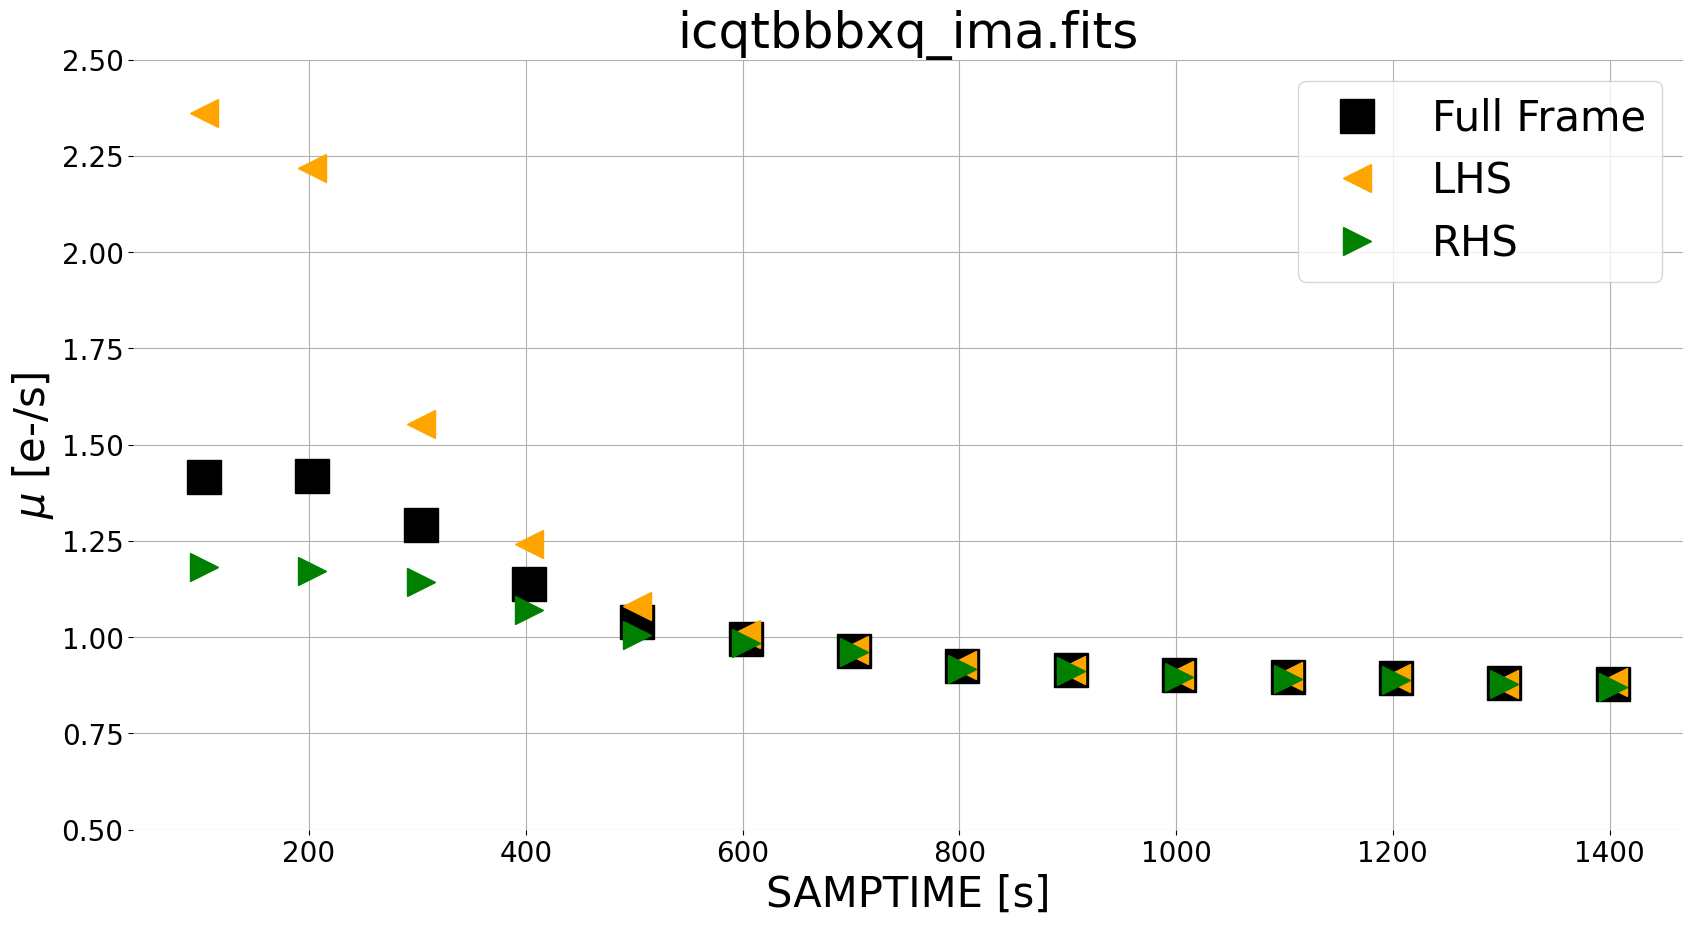

In [4]:
fig = plt.figure(figsize=(20, 10))

ima = f'orig/{file_id}_ima.fits'

path, filename = os.path.split(ima)
cube, integ_time = diff.read_wfc3(ima)


lhs_region = {"x0":50,"x1":250,"y0":100,"y1":900}
rhs_region = {"x0":700,"x1":900,"y0":100,"y1":900}

#Please use a limit that makes sense for your own data, when running your images through this notebook.
cube[np.abs(cube) > 3] = np.nan

diff_cube = diff.compute_diff_imas(cube, integ_time, diff_method="instantaneous")
median_diff_fullframe, median_diff_lhs, median_diff_rhs =\
diff.get_median_fullframe_lhs_rhs(diff_cube, lhs_region=lhs_region, rhs_region=rhs_region)

plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.rcParams.update({'font.size': 30})
plt.rcParams.update({'lines.markersize': 15})

diff.plot_ramp(ima, integ_time, median_diff_fullframe, median_diff_lhs, median_diff_rhs)

plt.ylim(0.5,2.5)
_=plt.title(filename)




Here, we use the `read_wfc3` funtion found in `ima_visualization_and_differencing.py` to grab the IMA data from all reads as a data cube and the integration time array, and implementing upper and lower limits on our pixel values to exclude sources when plotting our ramp. We take the instantaneous difference using the `compute_diff_imas` function from `ima_visualization_and_differencing.py`, which computes the difference as described in the equation above. Finally, We use the `plot_ramp` function from the module to plot the median count rate from the left side, right side, and full frame image.


For our scattered light exposure, we see  zodiacal light at a level of ~0.9e-/s in later reads, with the scattered light component affecting the first several reads where the mean count rate for the left side (orange triangles) is larger than the right side (green triangles). We can visualize this in 2 dimensions in the panel plot below, using the `panel_plot`.  

In the panel plot, we see that sources (small galaxies) are visible in the difference images using this new method. Note that this may complicate the analysis of the spatial background (e.g. left versus right) for images with extended targets, such as large galaxies. In this case, users may wish to adjust the regions of the detector used for the ramp plots. We therefore recommend inspecting both the panel plots as well as the ramp fits for diagnosing any issues with the data. 

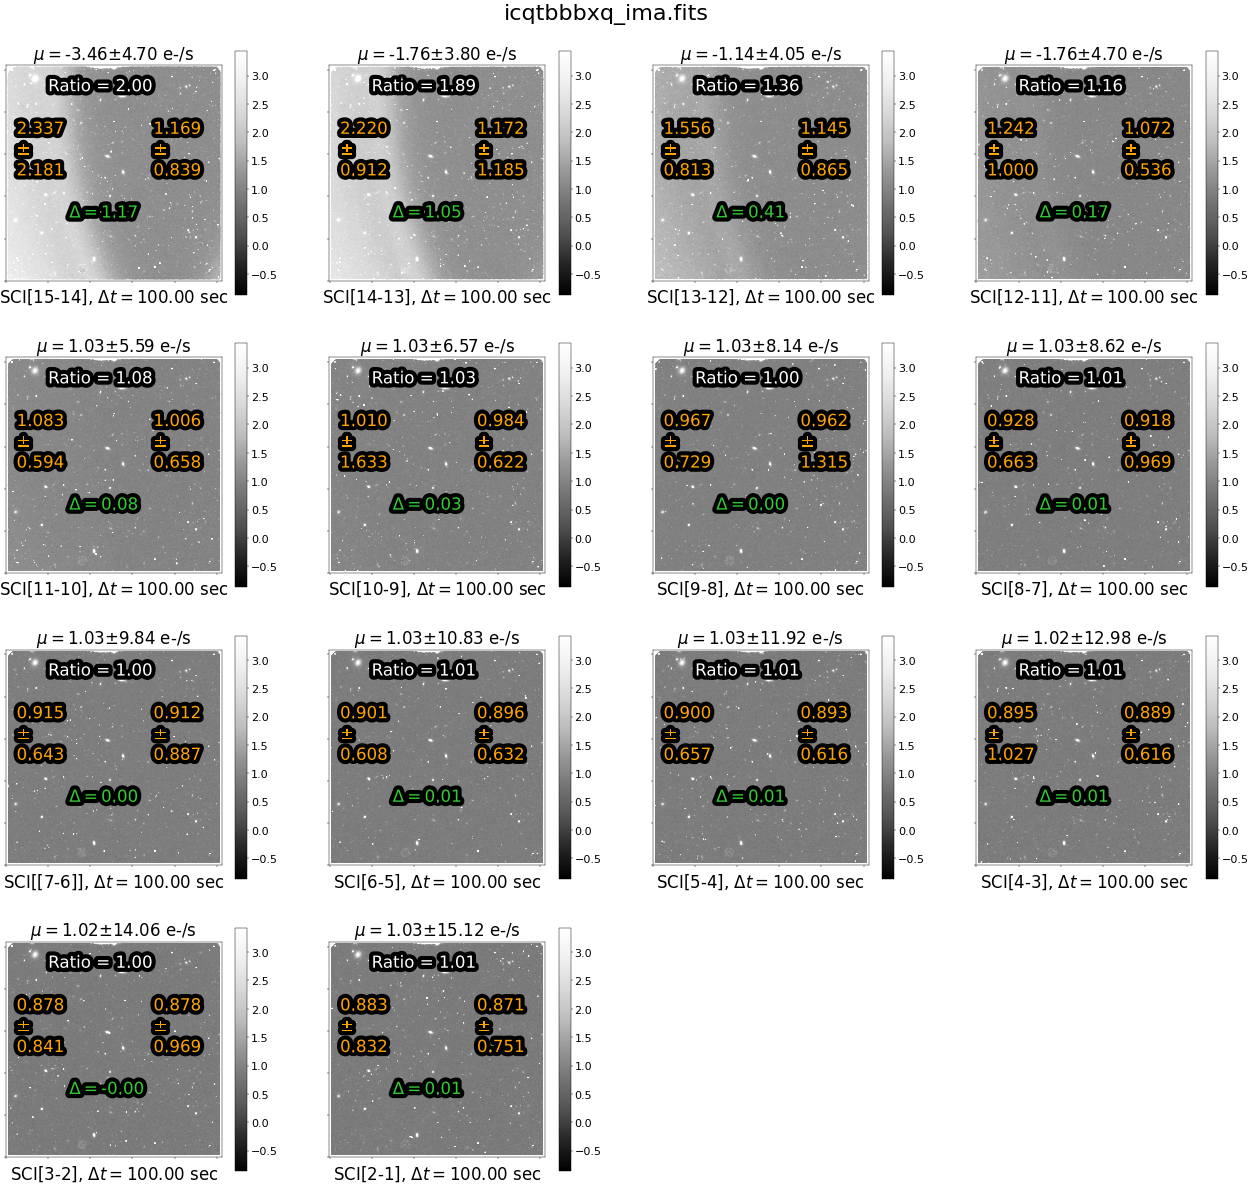

In [19]:
path,filename = os.path.split(ima)

cube, integ_time = diff.read_wfc3(ima)

lhs_region = {"x0":50,"x1":250,"y0":100,"y1":900}
rhs_region = {"x0":700,"x1":900,"y0":100,"y1":900}

median_fullframe, median_lhs, median_rhs = diff.get_median_fullframe_lhs_rhs(cube, lhs_region=lhs_region, rhs_region=rhs_region)

diff_cube = diff.compute_diff_imas(cube, integ_time, diff_method='instantaneous')

median_diff_fullframe, median_diff_lhs, median_diff_rhs = diff.get_median_fullframe_lhs_rhs(diff_cube, lhs_region=lhs_region, rhs_region=rhs_region)
standard_dev_fullframe, standard_dev_lhs, standard_dev_rhs = diff.get_std_fullframe_lhs_rhs(diff_cube, lhs_region=lhs_region, rhs_region=rhs_region)

fig_0 = diff.panel_plot(cube, integ_time, median_diff_fullframe, median_diff_lhs, median_diff_rhs, standard_dev_fullframe, standard_dev_lhs, standard_dev_rhs, diff_method='instantaneous')
_= fig_0.suptitle(filename, fontsize=40)
plt.subplots_adjust(bottom=0.25, right=0.9, top=0.95)

In this figure, we see that the ratio of instantaneous rate for the left versus right side of the image is ~1.0 for all but the first few reads (which are affected by scattered light). We choose to exclude reads with a ratio greater than 1.1 e-/s from the exposure and reprocess the image with `calwf3`. While this reduces the total exposure from 1403 to 1000 seconds, it removes the spatial component from the sky background and allows for a more accurate 'up-the-ramp' fit with `calwf3`.

## 4. Querying CRDS for the Reference File<a id="ref"></a>

Before running `calwf3`, we need to set some environment variables.

We will point to a subdirectory called crds_cache/ using the IREF environment variable, which is used for WFC3 reference files. Other instruments use other variables, e.g., JREF for ACS.

In [7]:
os.environ['CRDS_SERVER_URL'] = 'https://hst-crds.stsci.edu'
os.environ['CRDS_SERVER'] = 'https://hst-crds.stsci.edu'
os.environ['CRDS_PATH'] = './crds_cache'
os.environ['iref'] = './crds_cache/references/hst/wfc3/'

The code block below will query CRDS for the best reference files currently available for our dataset and update the header keywords to point to these new files. We will use the Python package *os* to run terminal commands. In the terminal, the line would be:

...where 'filename' is the name of your fits file.


**Warning: this cell may take a few minutes to complete.**

In [8]:
raw_file = f'{file_id}_raw.fits'


print( f"Querying CRDS for the reference file associated with {raw_file}.")
command_line_input = 'crds bestrefs --files {:} --sync-references=1 --update-bestrefs'.format(raw_file)
os.system(command_line_input)

Querying CRDS for the reference file associated with icqtbbbxq_raw.fits.


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfpc2_wf4tfile_0250.rmap       678 bytes  (1 / 140 files) (0 / 1.7 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfpc2_shadfile_0250.rmap       977 bytes  (2 / 140 files) (678 / 1.7 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfpc2_offtab_0250.rmap         642 bytes  (3 / 140 files) (1.7 K / 1.7 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfpc2_maskfile_0250.rmap       685 bytes  (4 / 140 files) (2.3 K / 1.7 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfpc2_idctab_0250.rmap         696 bytes  (5 / 140 files) (3.0 K / 1.7 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfpc2_flatfile_0250.rmap    30.0 K bytes  (6 / 140 files) (3.7 K / 1.7 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfpc2_dgeofile_0250.rmap       801 bytes  (7 / 140 files) (33.7 K / 1.7 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfpc2

CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_exstab_0250.rmap          745 bytes  (61 / 140 files) (1.2 M / 1.7 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_echsctab_0250.rmap        749 bytes  (62 / 140 files) (1.2 M / 1.7 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_disptab_0250.rmap         813 bytes  (63 / 140 files) (1.2 M / 1.7 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_darkfile_0338.rmap     56.2 K bytes  (64 / 140 files) (1.2 M / 1.7 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_crrejtab_0250.rmap        711 bytes  (65 / 140 files) (1.2 M / 1.7 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_cdstab_0250.rmap          745 bytes  (66 / 140 files) (1.2 M / 1.7 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_ccdtab_0252.rmap          893 bytes  (67 / 140 files) (1.2 M / 1.7 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/h

CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_acs_oscntab_0251.rmap          781 bytes  (122 / 140 files) (1.5 M / 1.7 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_acs_npolfile_0253.rmap       3.2 K bytes  (123 / 140 files) (1.5 M / 1.7 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_acs_mlintab_0250.rmap          646 bytes  (124 / 140 files) (1.5 M / 1.7 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_acs_mdriztab_0253.rmap         769 bytes  (125 / 140 files) (1.5 M / 1.7 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_acs_imphttab_0258.rmap         769 bytes  (126 / 140 files) (1.5 M / 1.7 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_acs_idctab_0256.rmap         1.5 K bytes  (127 / 140 files) (1.5 M / 1.7 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_acs_flshfile_0267.rmap       3.4 K bytes  (128 / 140 files) (1.5 M / 1.7 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/map

0

## 5. Reprocessing the Observation<a id="main"></a>

As discussed in the [introduction](#intro) to this notebook, the accuracy of the ramp fit performed during the CRCORR cosmic-ray rejection step of the pipeline determines the quality of the calibrated IR FLT data products. Given that a time variable background can compromise the quality of the ramp fit, observations affected by TVB will likely result in poor-quality calibrated FLT images ([Appendix: Variable Background Correction of the WFC3/IR 2021-01 ISR](https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/wfc3/documentation/instrument-science-reports-isrs/_documents/2021/2021-01.pdf).)

To address poorly calibrated FLT images where some reads are affected by scattered light TVB (as in our example observation), we can remove these reads and re-run `calwf3` to produce cleaner FLT images. We choose to exclude reads where the ratio of background signal is greater than 1.1 e-/s (see the notebook [IR IMA Visualization with An Example of Time Variable Background]() for a more complete demonstration of how we find this ratio).

The following reprocessing example is replacing section [7.10.1 of the WFC3 Data Handbook](https://hst-docs.stsci.edu/wfc3dhb/chapter-7-wfc3-ir-sources-of-error/7-10-time-variable-background). 

### 5.1 Re-running `calwf3` <a id="reprocess"></a>

Below, we select our excluded reads (in this case reads 11-15), which are at the beginning of the exposure. We set the DQ value to 1024 for these reads, prompting `calwf3` to flag all pixels in these reads as bad, effectively rejecting the reads.

In [9]:
raw_filepath = f'{file_id}_raw.fits'
reads = np.arange(11,16) #numpy arange creates an array including the start value (11) but excluding the stop value (16), so the array is actually 11-15. 
for read in reads:
    fits.setval(raw_filepath, extver=read, extname='DQ', keyword='pixvalue', value=1024)


calwf3(raw_filepath)


git tag: UNKNOWN

git branch: UNKNOWN

HEAD @: UNKNOWN





CALBEG*** CALWF3 -- Version 3.6.2 (May-27-2021) ***

Begin    09-May-2023 15:53:39 EDT





Input    icqtbbbxq_raw.fits

loading asn



LoadAsn:  Processing SINGLE exposure

Trying to open icqtbbbxq_raw.fits...

Read in Primary header from icqtbbbxq_raw.fits...

Creating new trailer file `icqtbbbxq.tra'.





CALBEG*** WF3IR -- Version 3.6.2 (May-27-2021) ***

Begin    09-May-2023 15:53:39 EDT

Input    icqtbbbxq_raw.fits

Output   icqtbbbxq_flt.fits

Trying to open icqtbbbxq_raw.fits...

Read in Primary header from icqtbbbxq_raw.fits...

APERTURE IR-FIX

FILTER   F140W

DETECTOR IR

Reading data from icqtbbbxq_raw.fits ...

CCDTAB   iref$t2c16200i_ccd.fits

CCDTAB   PEDIGREE=Ground

CCDTAB   DESCRIP =Reference data based on Thermal-Vac #3, gain=2.5 results for IR-4

CCDTAB   DESCRIP =Readnoise,gain,saturation from TV3,MEB2 values. ISRs 2008-25,39,50

    readnoise =20.2,19.8,19.9,20.1

    gain =2.34,2.37,2.31,2.38

DQICORR  

### 5.2 Comparing FLT Products <a id="compare"></a>

Please move your reprocessed images to a new directory with a different name each time you run this notebook.

In [10]:
reprocessed_flt = f'{file_id}_flt.fits'
reprocessed_ima = f'{file_id}_ima.fits'
original_flt = f'orig/{file_id}_flt.fits'
original_ima = f'orig/{file_id}_ima.fits'

Now, we can compare our original and reprocessed FLT products.

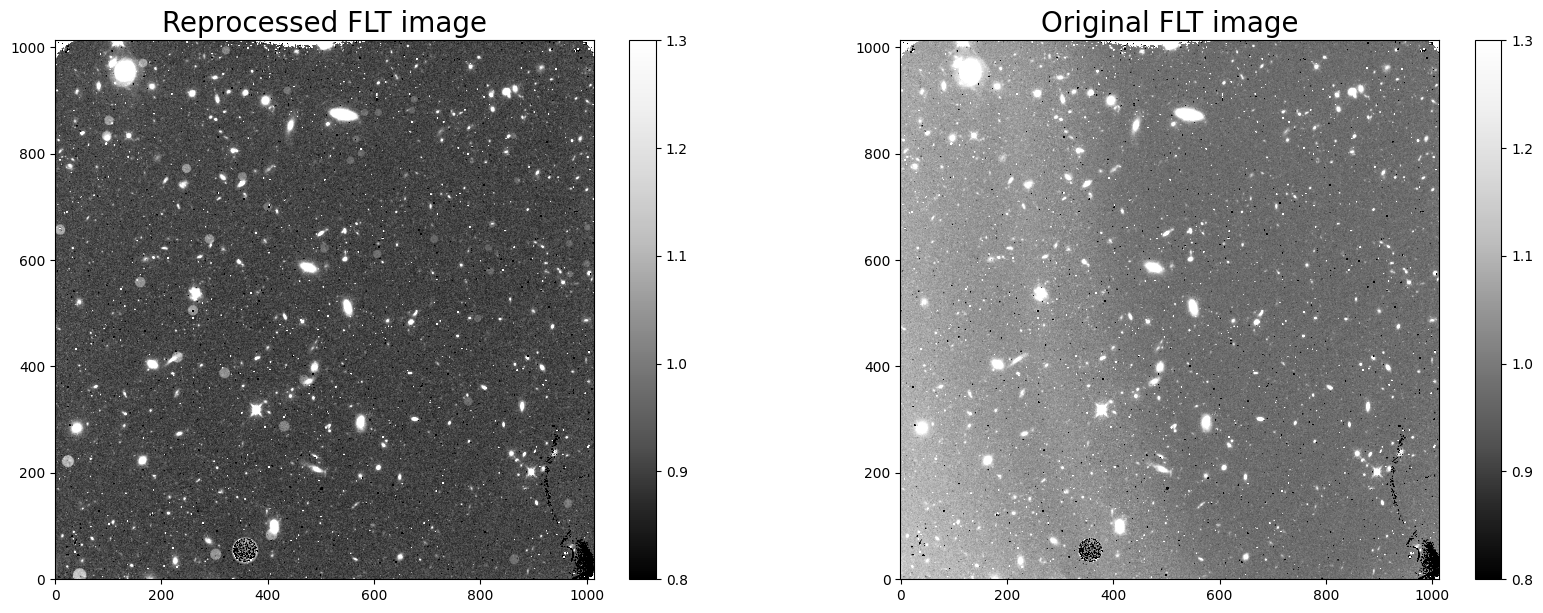

In [23]:

image_new = fits.getdata(reprocessed_flt)
image_old = fits.getdata(original_flt)

fig = plt.figure(figsize=(20, 7))
fig
rows = 1
columns = 2

#add the total exptime in the title 
ax1 = fig.add_subplot(rows, columns, 1)
ax1.set_title("Reprocessed FLT image", fontsize=20)
im1 = plt.imshow(image_new, vmin=0.8, vmax=1.3, origin='lower', cmap='Greys_r')
ax1.tick_params(axis='both', labelsize = 10)
cbar1 = plt.colorbar(im1, ax=ax1)
cbar1.ax.tick_params(labelsize=10)


ax2 = fig.add_subplot(rows,columns,2)
ax2.set_title("Original FLT image", fontsize=20)
im2 = plt.imshow(image_old, vmin=0.8, vmax=1.3, origin='lower',  cmap='Greys_r')
ax2.tick_params(axis='both', labelsize=10)
cbar2 = plt.colorbar(im2, ax=ax2)
cbar2.ax.tick_params(labelsize=10)

plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 



Text(0.5, 1.0, 'Original FLT')

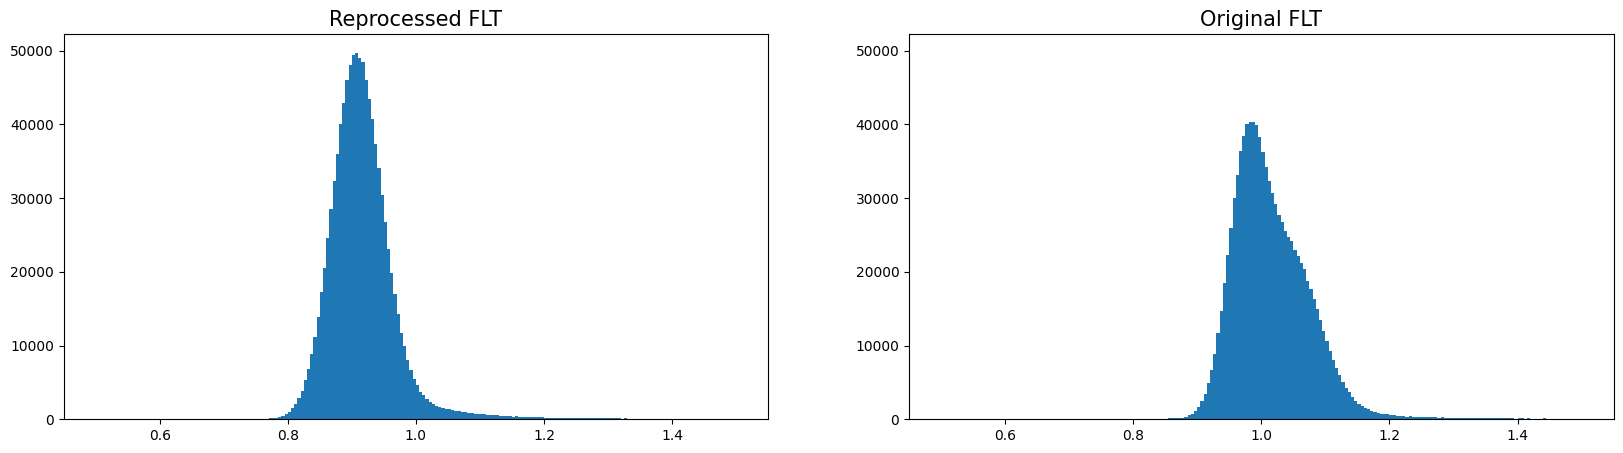

In [37]:
new_f = image_new.flatten()
old_f = image_old.flatten()

fig=plt.figure(figsize=(20,5))
ax1=fig.add_subplot(1,2,1)
ax2=fig.add_subplot(1,2,2)

n, bins, patches = ax1.hist(new_f,bins=200, range=(0.5,1.5))
n, bins, patches = ax2.hist(old_f,bins=200, range=(0.5,1.5))

ax2.sharey(ax1)

ax1.set_title("Reprocessed FLT", fontsize=15)
ax2.set_title("Original FLT", fontsize=15)

 The corrected FLT product, unlike the original FLT affected by scattered light, now has a gaussian distribution that is expected from the sky background.

This new image was produced by `calwf3` after masking the first 5 reads (not including the zero read) in the RAW file, reducing the effective exposure time from 1403 to 1000 seconds. While the total exposure is reduced from 1403 seconds to 1000 seconds (thus decreasing the overall S/N of the image), the background in the reprocessed image is now uniform over the entire field of view. We can see that the new FLT image is free of the Earth limb scattered light visible in the old FLT image. 

We update the FLT header keywords "EXPTIME" (in the primary header) and "SAMPTIME" (in the science header) to reflect the new total exposure time.

In [21]:

ima_orig = fits.open(original_ima)
        
hdr = ima_orig[0].header
NSAMP = hdr['NSAMP']
hdr1 = ima_orig[1].header
integ_time = np.zeros(shape=(NSAMP))
for i in range(1, NSAMP+1):
        integ_time[i-1] = ima_orig[('TIME', i)].header['PIXVALUE']
integ_time = integ_time[::-1]

dt = np.diff(integ_time)

final_time = integ_time[-1]

if (len(reads) > 0):
    for read in reads:
        index = len(integ_time)-read-1 #because the reads are stored in reverse order
        final_time -= dt[index]
        
        
print(f'The final exposure time after reprocessing is {final_time}.')
image_new[0].header['EXPTIME'] = final_time
image_new.flush()
image_new.close()

The final exposure time after reprocessing is 1000.0032699999998.


Finally, note that the reprocessed FLT product now includes a larger sky background in science pixels corresponding to IR "blobs", regions of reduced sensitivity due particulate matter on the channel selection mechanism (CSM) mirror([section 7.5 of the WFC3 Data Handbook](https://hst-docs.stsci.edu/wfc3dhb/chapter-7-wfc3-ir-sources-of-error/7-5-blobs)). 

The method for correcting IR images described in the notebook Correcting for Scattered Light in IR Exposures: Manually Subtracting Bad Reads (O'Connor, in prep.) provides FLT products without blobs, but that do include cosmic rays.

## 6. Drizzling Nominal and Reprocessed FLT Products <a id="drizzle"></a>

In our example we use an exposure ('icqtbbbxq') from image association 'ICQTBB020' acquired in visit BB of program [14037](https://www.stsci.edu/hst/observing/program-information). This visit consists of two orbits of two exposures each, and we now download the three other FLTs in the visit ('icqtbbc0q_flt.fits', 'icqtbbbrq_flt.fits', 'icqtbbbtq_flt.fits') and the pipeline drizzled DRZ product. 

To produce a clean DRZ image (without blob residuals), we can drizzle the four FLTs together (from the nominal exposures and the reprocessed exposure), replacing pixels flagged as blobs with those from the dithered (nominal) image.


In [13]:
data_list = Observations.query_criteria(obs_id=OBS_ID)

Observations.download_products(data_list['obsid'], project='CALWF3',  
                mrp_only=False, productSubGroupDescription=['FLT','DRZ'])


INFO: Found cached file ./mastDownload/HST/icqtbbbxq/icqtbbbxq_flt.fits with expected size 16583040. [astroquery.query]


Local Path,Status,Message,URL
str47,str8,object,object
./mastDownload/HST/icqtbb020/icqtbb020_drz.fits,COMPLETE,None,None
./mastDownload/HST/icqtbbbrq/icqtbbbrq_flt.fits,COMPLETE,None,None
./mastDownload/HST/icqtbbbtq/icqtbbbtq_flt.fits,COMPLETE,None,None
./mastDownload/HST/icqtbbbxq/icqtbbbxq_flt.fits,COMPLETE,None,None
./mastDownload/HST/icqtbbc0q/icqtbbc0q_flt.fits,COMPLETE,None,None


In [14]:
nominal_file_ids = ["icqtbbc0q", "icqtbbbrq", "icqtbbbtq"]
#nominal_file_ids = ["icxt27hoq"]
nominal_list = []
for nominal_file_id in nominal_file_ids:
    shutil.copy(f'mastDownload/HST/{nominal_file_id}/{nominal_file_id}_flt.fits', f'{nominal_file_id}_flt.fits')
    nominal_list.append(f'{nominal_file_id}_flt.fits')
print(nominal_list)

['icqtbbc0q_flt.fits', 'icqtbbbrq_flt.fits', 'icqtbbbtq_flt.fits']


Next, we update the image World Coordinate System of the reprocessed image in preparation for drizzling.

In [15]:
from stwcs import updatewcs
updatewcs.updatewcs(reprocessed_flt, use_db=True)



AstrometryDB service available...
- IDCTAB: Distortion model from row 4 for chip 1 : F140W
- IDCTAB: Distortion model from row 4 for chip 1 : F140W
Updating astrometry for icqtbbbxq
Accessing AstrometryDB service :
	https://mast.stsci.edu/portal/astrometryDB/observation/read/icqtbbbxq
AstrometryDB service call succeeded
Retrieving astrometrically-updated WCS "OPUS" for observation "icqtbbbxq"
Retrieving astrometrically-updated WCS "IDC_w3m18525i" for observation "icqtbbbxq"
Retrieving astrometrically-updated WCS "OPUS-GSC240" for observation "icqtbbbxq"
Retrieving astrometrically-updated WCS "IDC_w3m18525i-GSC240" for observation "icqtbbbxq"
Retrieving astrometrically-updated WCS "OPUS-HSC30" for observation "icqtbbbxq"
Retrieving astrometrically-updated WCS "IDC_w3m18525i-HSC30" for observation "icqtbbbxq"
Updating icqtbbbxq with:
	Headerlet with WCSNAME=OPUS
	Headerlet with WCSNAME=IDC_w3m18525i
	Headerlet with WCSNAME=IDC_w3m18525i-GSC240
	Headerlet with WCSNAME=IDC_w3m18525i-HSC3

['icqtbbbxq_flt.fits']

Finally, we combine the four FLT images with AstroDrizzle while exluding pixels flagged as blobs and replacing those pixels with those from dithered frames.

In [16]:
from drizzlepac import astrodrizzle
astrodrizzle.AstroDrizzle('icqtbb*flt.fits', output='f140w', preserve=False, build=False, context=False, skymethod='match', driz_separate=False, median=False, blot=False, driz_cr=False, final_bits='16')
#astrodrizzle.AstroDrizzle('*flt.fits', output='f105w', preserve=False, build=False, context=False, skymethod='match', driz_separate=False, median=False, blot=False, driz_cr=False, final_bits='16')

The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol
Setting up logfile :  astrodrizzle.log
AstroDrizzle log file: astrodrizzle.log
AstroDrizzle Version 3.5.1 started at: 15:54:02.207 (09/05/2023)

==== Processing Step  Initialization  started at  15:54:02.208 (09/05/2023)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 342.32386934251866  -44.54564257214722  
CRPIX : 555.5  493.5  
CD1_1 CD1_2  : -4.898034677110048e-06  -3.528668216092637e-05  
CD2_1 CD2_2  : -3.528668216092637e-05  4.898034677110048

Comparing the new DRZ image made with the reprocessed FLT product against the original pipeline DRZ image, we see that the new DRZ image no longer includes scattered light but has a slightly lower S/N due the reduced total exposure time from 1403 to 1000 seconds. 

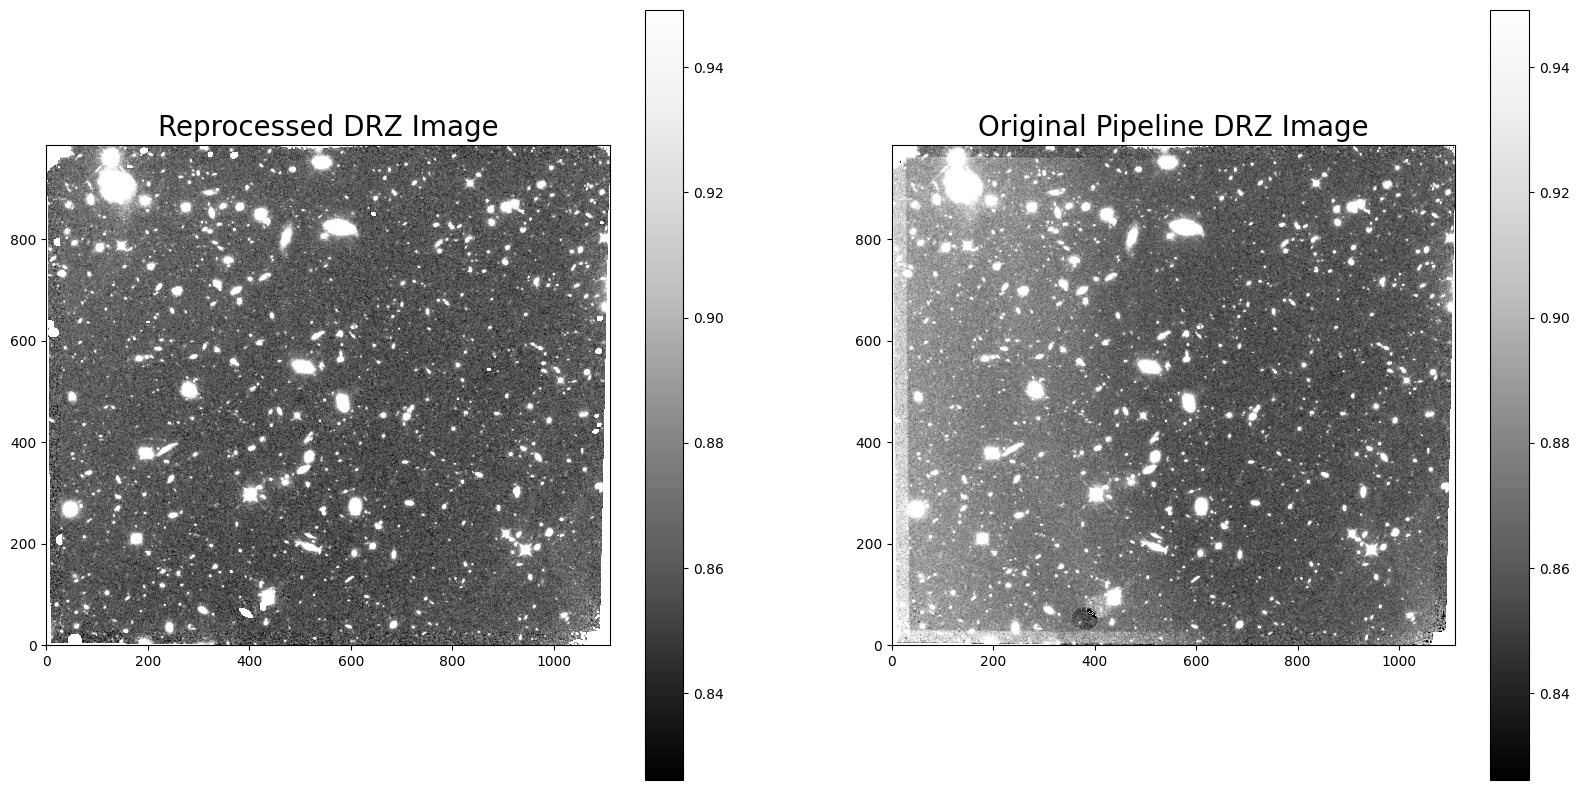

In [22]:
DRZ_image = fits.getdata("f140w_drz_sci.fits")
Orig_DRZ = fits.getdata('mastDownload/HST/icqtbb020/icqtbb020_drz.fits')

#DRZ_image = fits.getdata("f105w_drz_sci.fits")
#Orig_DRZ = fits.getdata('mastDownload/HST/icxt27020/icxt27020_drz.fits')

fig = plt.figure(figsize=(20,10))
rows = 1
columns = 2


#add the total exptime in the title 
ax1 = fig.add_subplot(rows, columns, 1)
ax1.set_title("Reprocessed DRZ Image", fontsize=20)
vmin,vmax = zscale(DRZ_image)
im1 = plt.imshow(DRZ_image, vmin=vmin, vmax=vmax, origin='lower', cmap='Greys_r')
_= plt.colorbar()

ax2 = fig.add_subplot(rows, columns, 2)
ax2.set_title("Original Pipeline DRZ Image", fontsize=20)
im2 = plt.imshow(Orig_DRZ, vmin=vmin, vmax=vmax, origin='lower', cmap='Greys_r')
_= plt.colorbar()


Text(0.5, 1.0, 'Original DRZ image')

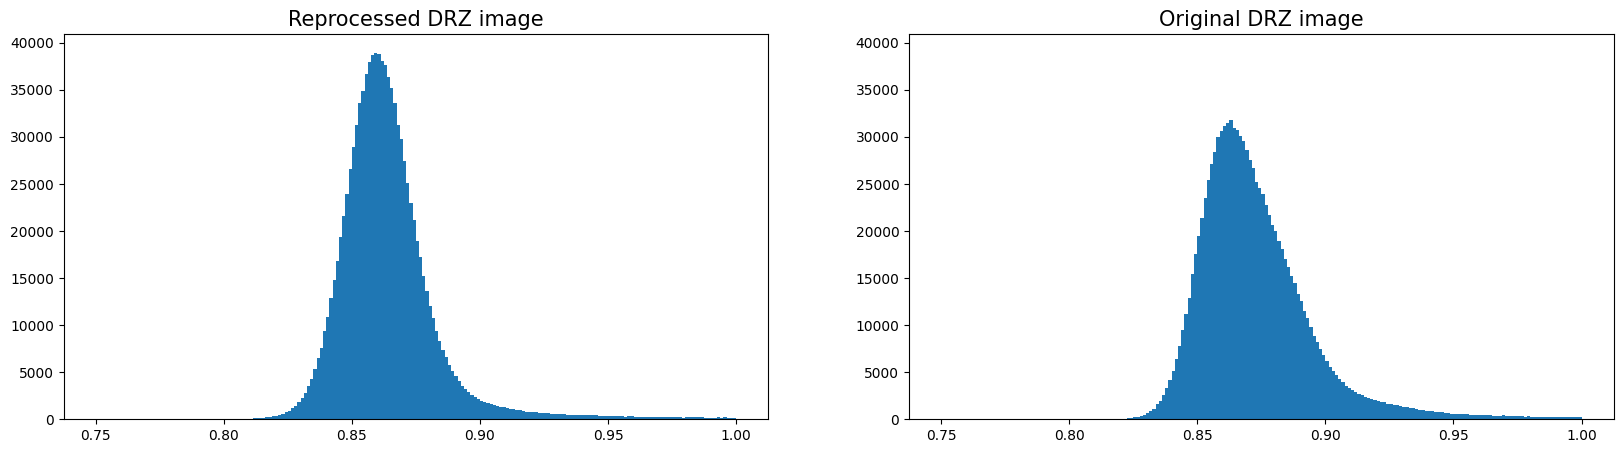

In [34]:
new_f = DRZ_image.flatten()
old_f = Orig_DRZ.flatten()

fig=plt.figure(figsize=(20,5))
ax1=fig.add_subplot(1,2,1)
ax2=fig.add_subplot(1,2,2)

n, bins, patches = ax1.hist(new_f,bins=200,range=(0.75,1))
n, bins, patches = ax2.hist(old_f,bins=200,range=(0.75,1))

ax2.sharey(ax1)

ax1.set_title("Reprocessed DRZ image",fontsize=15)
ax2.set_title("Original DRZ image",fontsize=15)

Just like the reprocessed FLT, the reprocessed DRZ product now has a guassian sky background. 

## 7. Conclusions <a id="conclusions"></a>

**Congratulations, you have completed the notebook.**

You should now be familiar with how to reprocess an observation affected by Earth limb scattered light by removing the first few reads and rerunning `calwf3`.

Thank you for following along! 

## Additional Resources <a id="add"></a>


Below are some additional resources that may be helpful. Please send any questions through the [HST Help Desk](https://stsci.service-now.com/hst).

- [WFC3 Website](https://www.stsci.edu/hst/instrumentation/wfc3)
    - [WFC3/UVIS CTE Website](https://www.stsci.edu/hst/instrumentation/wfc3/performance/cte)
- [WFC3 Instrument Handbook](https://hst-docs.stsci.edu/wfc3ihb)
- [WFC3 Data Handbook](https://hst-docs.stsci.edu/wfc3dhb)
- [Instrument Science Report WFC3 2021-01](https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/wfc3/documentation/instrument-science-reports-isrs/_documents/2021/2021-01.pdf)

## About this Notebook <a id="about"></a>


**Author:** Anne O'Connor, Jennifer Mack, Annalisa Calamida, Harish Khandrika -- WFC3 Instrument

**Updated On:** 2023-02-01

## Citations <a id="cite"></a>

If you use the following tools for published research, please cite the
authors. Follow these links for more information about citing the tools:

* [Citing `numpy`](https://numpy.org/citing-numpy/)
* [Citing `astropy`](https://www.astropy.org/acknowledging.html)
* [Citing `astroquery`](https://astroquery.readthedocs.io/en/latest/)
* [Citing `wfc3tools`](https://wfc3tools.readthedocs.io/en/latest/)
* [Citing `drizzlepac`](https://drizzlepac.readthedocs.io/en/latest/LICENSE.html)


If you use this notebook, or information from the WFC3 Data Handbook, Instrument Handbook,
or WFC3 ISRs for published research, please cite them:

* [Citing the WFC3 Data Handbook](https://hst-docs.stsci.edu/wfc3dhb#:~:text=Citation,%2C%20(Baltimore%3A%20STScI).)
* [Citing the WFC3 Instrument Handbook](https://hst-docs.stsci.edu/wfc3ihb#:~:text=Citation,14.0%E2%80%9D%20(Baltimore%3A%20STScI))
* [Instrument Science Report WFC3 2021-01](https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/wfc3/documentation/instrument-science-reports-isrs/_documents/2021/2021-01.pdf)
* Citing this notebook:
    Please cite the primary author and year, and hyperlink the notebook or WFC3 Library
***

[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 